# ML-7. Machine learning model hyperparateres optimisation

Task: Train logistic regression and random forest. Select hyperparameters using basic and advanced optimization methods(GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna). The maximum number of iterations should not exceed 50. Use f1-score as an optimization criterion.

In [1]:
#import libratiries 
import numpy as np #for matrix calculations
import pandas as pd #for data analysis and preprocessing
import matplotlib.pyplot as plt #for visualization
import seaborn as sns #for visualization

import sys
import os
import warnings

from sklearn import linear_model #linear models
from sklearn import tree #decision trees
from sklearn import ensemble #ensembles
from sklearn import metrics #metrics
#from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 

%matplotlib inline
plt.style.use('seaborn-v0_8-notebook')

## 1. Data overview

Data presented in CSV format. Each line represents a molecule.

The first column (Activity) contains experimental data describing the actual biological response [0, 1].
Other columns D1-D1776 represent molecular descriptors — these are calculated properties that can fix some characteristics of a molecule, such as size, shape, or composition of elements.
Pre-processing is not required, the data are already coded and normalized.

In [2]:
data = pd.read_csv('_train_sem09.csv')
data

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


The data look pretty balanced

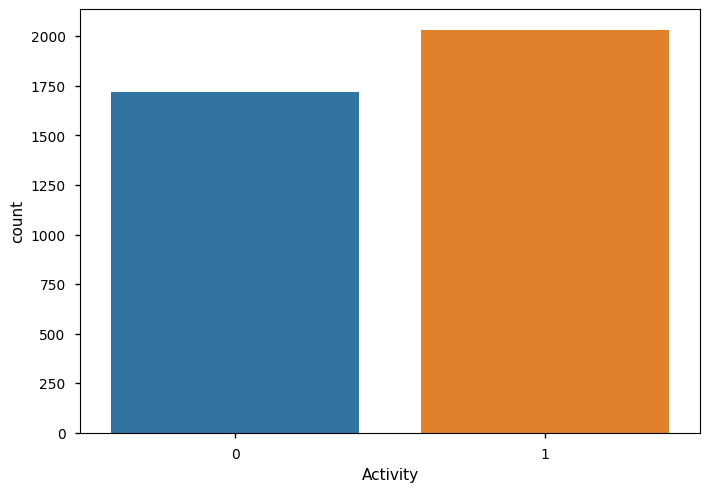

In [3]:
sns.countplot(data=data, x='Activity');

Create a matrix of observations $X$ and a vector of responses $y$

In [4]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Split data: 80% of the dataset goes into the training set and 20% of the dataset goes into the testing set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

## 2. Logistic regression hyperparameters optimization 

Let's set metrics that were obtained without additional settings, i.e. with default hyperparameter values to see our baseline

In [6]:
# create an object of the logistic regression class
log_reg = linear_model.LogisticRegression(max_iter=50)
# train a model minimizing logloss
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
print("F1_score train: {:.2f}".format(metrics.f1_score(y_train,y_train_pred )))
print("Accuracy test: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1_score train: 0.88
Accuracy test: 0.75
f1_score test: 0.79


/Users/anatolysavin/Desktop/PY/.conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We noticed that there is no convergence on values less than 500 interactions, while on all the range of the number of iterations it does not affect Accuracy and F1_score

### 2.1. Logistic regression: **GridSearchCV**

In [7]:
from sklearn.model_selection import GridSearchCV

# switching off warning output due to a large number of warnings about the lack of convergence
warnings.filterwarnings(action='ignore')
os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

param_grid = [{
              'solver': ['lbfgs', 'sag']}, # withoht regularisaion
              {'penalty': ['l2'] , # regularisaiton type
              'solver': ['lbfgs', 'sag'], # method
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # coef of regularisation
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search = GridSearchCV( 
        estimator=linear_model.LogisticRegression(
        random_state=42, #set the state to reproduce results each run
        max_iter=50, #number of iteration 
        ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    scoring = 'f1',
    verbose=False
)

%time grid_search.fit(X_train, y_train);




CPU times: user 682 ms, sys: 207 ms, total: 890 ms
Wall time: 32.2 s


In [8]:
print("accuracy test: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Best parameters: {}".format(grid_search.best_params_))

accuracy test: 0.80
f1_score test: 0.80
Best parameters: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}


Conclusion: Grid search (GridSearchCV) for selected criterion F1_Score allowed to achieve improvement of model parameters compared to default parameters even with a limited number of iterations

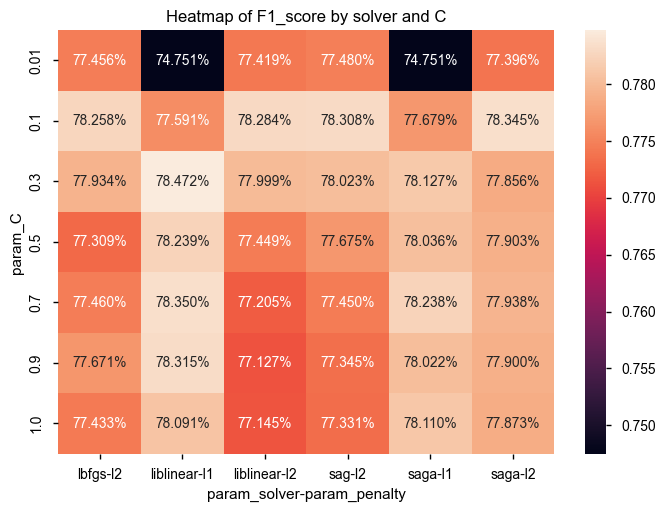

In [9]:
# let's visualize our grid
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns=['param_solver','param_penalty'])
sns.heatmap(visual, annot=True, fmt=".3%" )
plt.title('Heatmap of F1_score by solver and С') 
sns.set(rc={'figure.figsize':(12, 8)}) 

### 2.2. Logistic regression: **RandomizedSearchCV**

In [10]:
from sklearn.model_selection import RandomizedSearchCV

#np.linspace(start(from), stop(to), num=50(qty),dtype- data type)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1,
    scoring = 'f1'
)  

# switching off warnings due to the large number of convergence warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses


%time random_search.fit(X_train, y_train) 

print("accuracy train: {:.2f}".format(random_search.score(X_train, y_train)))
print("accuracy test: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Best parameters: {}".format(random_search.best_params_))

CPU times: user 1.38 s, sys: 31.9 ms, total: 1.41 s
Wall time: 8.23 s
accuracy train: 0.87
accuracy test: 0.78
f1_score test: 0.78
Best parameters: {'solver': 'sag', 'penalty': 'l2', 'C': 0.56}


Conclusion: without loss of quality, the random search found another set of parameters and spent five times less time compared to a full search of the grid.

### 2.3. Logistic regression: **Hyperopt**


In [11]:
# importing all required libraries
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval
# fmin - base function calling our target functional 
# tpe - method of optimisation
# hp - includes a set of methods for declaring a hyperparameter search space
# trails - stores logging results

print("Version of Hyperopt : {}".format(hyperopt.__version__))

Version of Hyperopt : 0.2.7


In [12]:
# creating an objective function

def hyperopt_lr(space, X=X_train, y=y_train):
    solver=space['solver']['solver']
    penalty=space['solver']['penalty']
    # creating our model
    model = linear_model.LogisticRegression(
        random_state=42, 
        max_iter=50, 
        penalty=penalty, 
        C=space['C'], 
        solver=solver 
      )
    # training the model
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    # Because fmin() tries to minimize the objective, this function must return the negative score
    return -score

In [13]:
%%time

# setting parameters space

space={
       'solver':  hp.choice('x_solver',[
                                       {'solver':'newton-cg', 'penalty': hp.choice('p_newton',['none','l2'])},
                                        {'solver':'lbfgs', 'penalty': hp.choice('p_lbfgs',['none','l2'])},
                                        {'solver': 'liblinear', 'penalty': hp.choice('p_lib',['l1','l2'])}, 
                                        {'solver': 'sag', 'penalty': hp.choice('p_sag',['l2','none'])}, 
                                        {'solver':'saga', 'penalty':hp.choice('p_saga',['l1','l2'])}
                                        ]),
        'C': hp.uniform('x_C',0,1)
        }


# let's start searching the best combination 

trials = Trials() # stores each try

best=fmin(hyperopt_lr, # our function 
          space=space, # parameters space
          algo=tpe.suggest, # default optimisation algorithm 
          max_evals=20, # max iteration
          trials=trials, # results of each try
          #rstate=np.random.RandomState(random_state)
          rstate=np.random.default_rng(42)
         )
print("Best parameters {}".format(best))
best_params = hyperopt.space_eval(space, best)
print(best_params)
# metrics for our test data
model = linear_model.LogisticRegression(
        random_state=42, 
        max_iter=50, 
        penalty=best_params['solver']['penalty'],
        C=best_params['C'],
        solver=best_params['solver']['solver']
       )


model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy test: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 20/20 [00:40<00:00,  2.04s/trial, best loss: -0.9965678627145085]
Best parameters {'p_newton': 0, 'x_C': 0.07366102545052411, 'x_solver': 0}
{'C': 0.07366102545052411, 'solver': {'penalty': 'none', 'solver': 'newton-cg'}}
f1_score train: 1.00
accuracy test: 0.70
f1_score test: 0.73
CPU times: user 3min 42s, sys: 51.2 s, total: 4min 33s
Wall time: 48.4 s


The result is unsatisfactory. Apparently, the model with the newton-cg method suffers of overfitting. The optimization algorithm was unable to leave the f1-score=1 zone on the training set. On the test sample, f1_score = 0.73 is lower than the results obtained by other methods of parameter selection.

Let's try to exclude newton-cg from the parameter space.

In [14]:
%%time

# let's set the search space for hyperparameters without 'newton-cg'

space={
       'solver':  hp.choice('x_solver',[
#                                       {'solver':'newton-cg', 'penalty': hp.choice('p_newton',['none','l2'])},
                                        {'solver':'lbfgs', 'penalty': hp.choice('p_lbfgs',['none','l2'])},
                                        {'solver': 'liblinear', 'penalty': hp.choice('p_lib',['l1','l2'])}, 
                                        {'solver': 'sag', 'penalty': hp.choice('p_sag',['l2','none'])}, 
                                        {'solver':'saga', 'penalty':hp.choice('p_saga',['l1','l2'])}
                                        ]),
        'C': hp.uniform('x_C',0,1)
        }



# running the search

trials = Trials() 

best=fmin(hyperopt_lr, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20,
          trials=trials, 
          #rstate=np.random.RandomState(random_state)
          rstate=np.random.default_rng(42)
         )
print("Best parameters {}".format(best))
best_params = hyperopt.space_eval(space, best)
print(best_params)
# test metrics
model = linear_model.LogisticRegression(
        random_state=42, 
        max_iter=50, 
        penalty=best_params['solver']['penalty'],
        C=best_params['C'],
        solver=best_params['solver']['solver']
       )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy test: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 20/20 [00:18<00:00,  1.10trial/s, best loss: -0.8780185758513932]
Best parameters {'p_lbfgs': 1, 'x_C': 0.9877372119600353, 'x_solver': 0}
{'C': 0.9877372119600353, 'solver': {'penalty': 'l2', 'solver': 'lbfgs'}}
f1_score train: 0.88
accuracy test: 0.75
f1_score test: 0.78
CPU times: user 30.9 s, sys: 16.8 s, total: 47.7 s
Wall time: 18.3 s


We were able to improve the F1_score on the test set by excluding the overfitting method from the search space.

Let's check whether this result can be improved by further calculations.

In [15]:
%%time

# let's continue the search

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=100, # максимальное количество итераций
          trials=trials, # логирование результатов
          #rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
          rstate=np.random.default_rng(42)
         )
print("Best parameters {}".format(best))

best_params = hyperopt.space_eval(space, best)
print(best_params)

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
        random_state=42, 
        max_iter=50, 
        penalty=best_params['solver']['penalty'],
        C=best_params['C'],
        solver=best_params['solver']['solver']
#        tol=best_params['tol'], 
#        l1_ratio=best_params['l1_ratio']
        )


model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy test: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 100/100 [00:45<00:00,  1.77trial/s, best loss: -0.8868274582560297]
Best parameters {'p_lib': 1, 'x_C': 0.9962588981005635, 'x_solver': 1}
{'C': 0.9962588981005635, 'solver': {'penalty': 'l2', 'solver': 'liblinear'}}
f1_score train: 0.89
accuracy test: 0.75
f1_score test: 0.79
CPU times: user 1min 34s, sys: 1min 16s, total: 2min 50s
Wall time: 45.4 s


CONCLUSION: HYPEROPT with TPE optimizer has a number of advantages: it quickly reaches the region of optimal values, the result can be improved by continuing calculations from the stop point. At the same time, you need to be careful, since the algorithm may get stuck in a local extremum. Unfortunately, we did not achieve a value better than the result obtained by exhaustive search over the grid, but the values are very close.

### 2.4. Logistic regression: **Optuna**

In [16]:
import optuna

print("Version of Optuna: {}".format(optuna.__version__))

Version of Optuna: 3.3.0


Let's try Optuna and this time we will use cross validation on training set to overcome problem with 'newton-cg'. Unfortunately, it did not help us so we eventually had to exclude 'newton-cg' despite it was very efficient method showed very high score on the training data. 

In [19]:
# ОСТОРОЖНО: ВРЕМЯ ВЫПОЛНЕНИЯ ЭТОГО БЛОКА ПОРЯДКА 5 МИНУТ!!!

# отключим вывод предупреждений из-за большого количества предупреждений об отсутствии сходимости
warnings.filterwarnings(action='ignore')
os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

def optuna_lr(trial):

# определяем параметры

        x_C = trial.suggest_int('Cs',1,10)
        cv = 5
        solver = trial.suggest_categorical('solver', (
#               'newton-cg', -- попытка избежать переобучения с использование кроссвалидации не дала успеха
                'lbfgs', 
                'liblinear',
                'sag',
                'saga'))
        penalty = trial.suggest_categorical('penalty',('l2','l2'))       
        
      
# создаем модель - решили попробовать кросс-валидацию
        model = linear_model.LogisticRegressionCV(
                cv=cv,
                random_state=42, 
                max_iter=50, 
                penalty=penalty,
                Cs=x_C,
                solver=solver,
                scoring='f1'
        )

# обучаем модель
        model.fit(X_train, y_train)

        score = model.score(X_train, y_train)

        return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"

sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(study_name="LogisticRegressionClassifier", direction="maximize", sampler=sampler)

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=5)

[I 2023-09-08 21:44:49,249] A new study created in memory with name: LogisticRegressionClassifier
[I 2023-09-08 21:44:51,361] Trial 0 finished with value: 0.8410413476263399 and parameters: {'Cs': 4, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 0 with value: 0.8410413476263399.
[I 2023-09-08 21:45:36,189] Trial 1 finished with value: 0.852328431372549 and parameters: {'Cs': 9, 'solver': 'saga', 'penalty': 'l2'}. Best is trial 1 with value: 0.852328431372549.
[I 2023-09-08 21:45:43,691] Trial 2 finished with value: 0.8872366790582404 and parameters: {'Cs': 2, 'solver': 'sag', 'penalty': 'l2'}. Best is trial 2 with value: 0.8872366790582404.
[I 2023-09-08 21:45:52,060] Trial 3 finished with value: 0.8746139592340951 and parameters: {'Cs': 2, 'solver': 'saga', 'penalty': 'l2'}. Best is trial 2 with value: 0.8872366790582404.
[I 2023-09-08 21:46:12,058] Trial 4 finished with value: 0.8581081081081081 and parameters: {'Cs': 6, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 2 w

In [20]:
# metrics on the training set with cross validation
print("Best parameters: {}".format(study.best_params))
print("f1_score train (cross validation): {:.2f}".format(study.best_value))

Best parameters: {'Cs': 2, 'solver': 'sag', 'penalty': 'l2'}
f1_score train (cross validation): 0.89


In [21]:
# test set metrics
model = linear_model.LogisticRegressionCV(
                **study.best_params,
                random_state=42, 
                max_iter=50,
        )


model.fit(X_train, y_train)

print("accuracy test: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy test: 0.75
f1_score test: 0.79


CONCLUSION: 1) Using cross_validation on the training set to overcome the overfitting problem with the 'newton-cg' method was not successful. The optimizer came to the area F1_score = 1 on the training set and the result on the test set was no more than 0.73. The 'newton-cg' method had to be excluded from the parameters. 2) The use of cross-validation on the test sample did not bring a significant improvement for f1_score on the test sample, while the computation time increased significantly.

In [22]:
# let's try to improve adding more trials

study.optimize(optuna_lr, n_trials=5)

[I 2023-09-08 21:48:21,759] Trial 5 finished with value: 0.8515337423312883 and parameters: {'Cs': 9, 'solver': 'sag', 'penalty': 'l2'}. Best is trial 2 with value: 0.8872366790582404.
[I 2023-09-08 21:48:22,062] Trial 6 finished with value: 0.7231944786788266 and parameters: {'Cs': 1, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 2 with value: 0.8872366790582404.
[I 2023-09-08 21:48:22,968] Trial 7 finished with value: 0.9067901234567901 and parameters: {'Cs': 2, 'solver': 'lbfgs', 'penalty': 'l2'}. Best is trial 7 with value: 0.9067901234567901.
[I 2023-09-08 21:48:25,165] Trial 8 finished with value: 0.7233727810650886 and parameters: {'Cs': 1, 'solver': 'saga', 'penalty': 'l2'}. Best is trial 7 with value: 0.9067901234567901.
[I 2023-09-08 21:48:43,978] Trial 9 finished with value: 0.8413329257107918 and parameters: {'Cs': 4, 'solver': 'saga', 'penalty': 'l2'}. Best is trial 7 with value: 0.9067901234567901.


In [23]:
# training set results
print("Best parameters {}".format(study.best_params))
print("f1_score train: {:.2f}".format(study.best_value))

Best parameters {'Cs': 2, 'solver': 'lbfgs', 'penalty': 'l2'}
f1_score train: 0.91


In [24]:
# test set metrics
model = linear_model.LogisticRegressionCV(
                **study.best_params,
                random_state=42, 
                max_iter=50,
        )


model.fit(X_train, y_train)

print("accuracy test: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy test: 0.74
f1_score test: 0.78


It seems that we are again entering the area of overfitting - the metric improved on the training set, but worsened on the test set.

## 3. Random forest hyperparameters optimization 

Let' see the baseline. All parameters are set by default:

In [25]:
# create a random forest class object

rf = ensemble.RandomForestClassifier(random_state=42)

# train the model
rf.fit(X_train, y_train)
# metrics for test and training sets
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.83


Now let’s set the hyperparameter grid:

* 'n_estimators' - number of trees in the forest, default = 100

* 'min_samples_leaf' - the minimum number of objects in the leaf;
* 'max_depth': maximum tree depth, should not be too large, otherwise there will be overfitting;

We will try RandomizedSearchCV() and then GridSearchCV()

In [26]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  

%time random_search_forest.fit(X_train, y_train) 

y_train_pred = random_search_forest.predict(X_train)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy test: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Best parameters: {}".format(random_search_forest.best_params_))

CPU times: user 1.19 s, sys: 144 ms, total: 1.33 s
Wall time: 12.4 s
f1_score train: 0.94
accuracy test: 0.81
f1_score test: 0.84
Best parameters: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 35}


In [27]:
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5,7],
              'max_depth': [10,15,20,25]
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

%time grid_search_forest.fit(X_train, y_train) 

y_train_pred = grid_search_forest.predict(X_train)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy test: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Best parameters: {}".format(grid_search_forest.best_params_))

CPU times: user 1.36 s, sys: 79.3 ms, total: 1.44 s
Wall time: 31.1 s
f1_score train: 0.94
accuracy test: 0.81
f1_score test: 0.83
Best parameters: {'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 130}


We can see that RandomizedSearchCV found slightly better results and spent significantly less time. All results are similar to baseline.

### 3. Random forest hyperparameters optimization: **Hyperopt**

In [28]:
# let's set parameters space
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # create a model with parameters received

    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # train the model
    model.fit(X, y)

    score = metrics.f1_score(y, model.predict(X))
    
    # in case of cross validation use the following code with the same number of clusters
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # return negative as we mimimise the score
    return -score

In [29]:
%%time
# run the search

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # our objective function
          space=space, # hyperparameters space
          algo=tpe.suggest, # default algorithm
          max_evals=20, # max number of trials
          trials=trials, # result of each trial
          rstate=np.random.default_rng(42) # set the random state to reproduce results
         )
print(" Best parameters {}".format(best))

100%|██████████| 20/20 [00:21<00:00,  1.08s/trial, best loss: -0.9860031104199067]
 Best parameters {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: user 21.5 s, sys: 156 ms, total: 21.7 s
Wall time: 21.7 s


In [30]:
# metrics for test set
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy test: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score train: 0.99
accuracy test: 0.81
f1_score test: 0.84


This is a good result but RandomSearch provided the same f1_score for less time. As the time is not a critical factor for us let's see if we can improve our metrics with more trials. Let's continue...

In [31]:
# to continue search 
# we have to increase max_evals strictly more than the previous run  
# we also have to use previous trials
best=fmin(hyperopt_rf, # our objective function
          space=space, # param space
          algo=tpe.suggest, # bayesian algorithm by default
          max_evals=30, # max iteration
          trials=trials, # result of each trial
          rstate=np.random.default_rng(42)
         )
print("Best parameters {}".format(best))

100%|██████████| 30/30 [00:14<00:00,  1.44s/trial, best loss: -0.9925187032418953]
Best parameters {'max_depth': 21.0, 'min_samples_leaf': 2.0, 'n_estimators': 161.0}


In [32]:
# metrics for test set
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy test: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score train: 0.99
accuracy test: 0.81
f1_score test: 0.83


Unfortunately, in our case we could not improve results with hyperopt adding more itarations but it stays very close to what we found using all optimization methods shown above.

## 4. SUMMARY

__We noticed that Random Forrest Trees provided sligtly better f1_score than logistic regression.__ 

__The overall recommedation for best model parameters would be RandomForrestClassifier {'max_depth': 18, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}.__

__These parameters found by HYPEROPT for Random Forrest Trees and these are the best cost efficient model hyperpatmeters we explored in this research as it has less max_depth and uses less number of estimators.__